In [ ]:
import sys
import glob
from pathlib import Path

import json

import matplotlib as mpl
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
rc('text', usetex=True)
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 36})
mpl.rcParams.update({'lines.linewidth': 2.5})
plt.rcParams["axes.formatter.use_mathtext"] = True

import numpy as np
np.set_printoptions(precision=9)
from numpy.linalg import eig, inv
import pandas as pd
import math
import cmath

import scipy.optimize as opt
import scipy.stats as st

from time import sleep
from tqdm.notebook import tqdm

C:\Users\Aditya\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe


In [ ]:
atom_data_file = r'Your path here\\atom_data.json'
expt_params_file = r'Your path here\\experimental_parameters.json'

data_storage_path = Path(r'Your path here')

In [ ]:
with open(expt_params_file,'r') as file:
    expt_params = json.load(file)

print(expt_params) 

{'w_g_ax': 6e-06, 'w_g_tr': 6e-06, 'w_sw_ax': 6e-06, 'w_sw_tr': 2e-06, 'phi_f': 0.0, 'omega_y_c': 34557519.1895, 'omega_y_s': 31415926.5359, 'omega_x_c': 6283185.30718, 'omega_x_s': 10882796.1854, 't_gate': 5e-05}


In [52]:
# Universal constants
e = 1.602E-19
c = 2.99792E8
epsilon_0 = 8.85E-12
h = 6.626E-34
hbar = h/(2*math.pi)
a0 = 0.529E-10
fine_structure = e**2/(4*math.pi*epsilon_0*hbar*c)

### Atom properties

In [ ]:
with open(atom_data_file,'r') as file:
    qubit = json.load(file)

atom = "Sr_88"

mass = qubit[atom]["mass"]

lambda_transition = qubit[atom]["lambda_transition"]
A = qubit[atom]["A"]
nu_transition = {i: c/lambda_transition[i] for i in lambda_transition.keys()}
omega_transition = {i: 2*math.pi*nu_transition[i] for i in nu_transition.keys()}
k_transition = {i: 2*math.pi/lambda_transition[i] for i in lambda_transition.keys()}
transitions_list = list(lambda_transition.keys())

manifolds_list = ["S12", "D32", "D52", "P12", "P32"]
J = [0.5, 1.5, 2.5, 0.5, 1.5]

In [54]:
qubit_manifold = ['S12', 'S12']
qubit_m = [-0.5, 0.5]

In [55]:
omega_fine = omega_transition['P32_S12'] - omega_transition['P12_S12']

### Laser Parameters

In [56]:
class Beam:
    def __init__(self, P, wt, wl, pol, lambda_and_detuning=None):

        self.P = P
        self.wt = wt
        self.wl = wl
        self.pol = pol
        self.E = math.sqrt(4*P/(math.pi*epsilon_0*c*wt*wl))

        if lambda_and_detuning is None:
            self.lambda_laser = None
            self.omega_laser = None
            self.k_laser = None
            self.Delta_minus = None
            self.Delta_plus = None

        if lambda_and_detuning is not None:
            self.omega_laser = 2*math.pi*c/lambda_and_detuning[0] - 2*np.pi*lambda_and_detuning[1]
            
            self.Delta_minus = {
            'P12_D32' : self.omega_laser - omega_transition['P12_D32'],
            'P32_D52' : self.omega_laser - omega_transition['P32_D52'],
            'P32_D32' : self.omega_laser - omega_transition['P32_D32'],
            'P12_S12' : self.omega_laser - omega_transition['P12_S12'],
            'P32_S12' : self.omega_laser - omega_transition['P32_S12'],
            }

            self.Delta_plus = {
            'P12_D32' : self.omega_laser + omega_transition['P12_D32'],
            'P32_D52' : self.omega_laser + omega_transition['P32_D52'],
            'P32_D32' : self.omega_laser + omega_transition['P32_D32'],
            'P12_S12' : self.omega_laser + omega_transition['P12_S12'],
            'P32_S12' : self.omega_laser + omega_transition['P32_S12'],
            }
    
    def set_laser_freq(self,lambda_and_detuning):
        self.omega_laser = 2*math.pi*c/lambda_and_detuning[0] - 2*np.pi*lambda_and_detuning[1]
        
        self.Delta_minus = {
        'P12_D32' : self.omega_laser - omega_transition['P12_D32'],
        'P32_D52' : self.omega_laser - omega_transition['P32_D52'],
        'P32_D32' : self.omega_laser - omega_transition['P32_D32'],
        'P12_S12' : self.omega_laser - omega_transition['P12_S12'],
        'P32_S12' : self.omega_laser - omega_transition['P32_S12'],
        }

        self.Delta_plus = {
        'P12_D32' : self.omega_laser + omega_transition['P12_D32'],
        'P32_D52' : self.omega_laser + omega_transition['P32_D52'],
        'P32_D32' : self.omega_laser + omega_transition['P32_D32'],
        'P12_S12' : self.omega_laser + omega_transition['P12_S12'],
        'P32_S12' : self.omega_laser + omega_transition['P32_S12'],
        }

### Trap parameters

In [ ]:
omega_y_c = expt_params['omega_y_c']
omega_y_s = expt_params['omega_y_s']
omega_x_c = expt_params['omega_x_c']
omega_x_s = expt_params['omega_x_s']

eta_y_s = np.sqrt(2) * (2 * np.pi / lambda_transition['P12_S12']) * np.sin(np.pi/3) * np.sqrt(hbar / 2 / mass / omega_y_s)

eta_y_s

0.0617092755048908

### Gate time

In [ ]:
t_gate = expt_params['t_gate']

### Matrix elements

In [57]:
def fine_mat(transition, Jf, mf, Ji, mi, J_excited, beam, pol_conj=False):

    pol_i = beam.pol
    if pol_conj:
        pol_i = [beam.pol[1], beam.pol[0], beam.pol[2]]
    
    sign = (-1)**(Jf+Ji+np.max([Jf,Ji])-mf)
    pre_factor1 = e*beam.E/(hbar)
    pre_factor2 = math.sqrt(3*A[transition]*(2*J_excited+1)/(4*c*fine_structure*k_transition[transition]**3))
    factor = wigner_3j(Jf,1,Ji,-mf,1,mi)*pol_i[0]+wigner_3j(Jf,1,Ji,-mf,-1,mi)*pol_i[1] + wigner_3j(Jf,1,Ji,-mf,0,mi)*pol_i[2]
    mat_ele = sign*pre_factor1*pre_factor2*factor
    return mat_ele

def fine_mat_scatter(transition, Jf, mf, Ji, mi, J_excited, s, pol_conj=False):

    if pol_conj:
        s = ((-1)**(s%2))*s
    sign = (-1)**(Jf+Ji+np.max([Jf,Ji])-mf)
    pre_factor2 = math.sqrt(A[transition]*(2*J_excited+1)/(c*k_transition[transition])**3)
    factor = wigner_3j(Jf,1,Ji,-mf,s,mi)
    mat_ele = sign*pre_factor2*factor
    return mat_ele

### Normalized Two-photon Rabi frequency

In [58]:
def two_photon_Rabi(manifold_i, m_i, beam1, beam2):

    Rabi = 0.0
    for f in range(len(manifolds_list)):
        manifold_f = manifolds_list[f]
        transition = manifold_f+'_'+manifold_i
        if transition in k_transition:
            J_k = J[manifolds_list.index(manifold_f)]
            for m_k in np.linspace(-J_k, J_k, int(2*J_k+1)):
                J_i = J[manifolds_list.index(manifold_i)]
                Rabi += fine_mat(transition,J_i,m_i,J_k,m_k,J_k,beam2)*fine_mat(transition,J_k,m_k,J_i,m_i,J_k,beam1)/beam1.Delta_minus[transition]
                Rabi -= fine_mat(transition,J_i,m_i,J_k,m_k,J_k,beam1)*fine_mat(transition,J_k,m_k,J_i,m_i,J_k,beam2)/beam1.Delta_plus[transition]
    return float(Rabi)

### Normalized Photon scattering rate

In [59]:
def chi(manifold_i, m_i, manifold_f, m_f, s, beam):

    chi = 0.0
    for k in range(len(manifolds_list)):
        manifold_k = manifolds_list[k]
        transition_ki = manifold_k+'_'+manifold_i
        transition_kf = manifold_k+'_'+manifold_f
        if transition_ki in k_transition and transition_kf in k_transition:
            omega_laser = beam.omega_laser
            omega_fi = 2*math.pi*c*(1.0/lambda_transition[transition_ki]-1.0/lambda_transition[transition_kf])
            if omega_laser > omega_fi:
                J_k = J[manifolds_list.index(manifold_k)]
                for m_k in np.linspace(-J_k, J_k, int(2*J_k+1)):
                    J_i = J[manifolds_list.index(manifold_i)]
                    J_f = J[manifolds_list.index(manifold_f)]
                    
                    chi += ((omega_laser-omega_fi)**1.5)*fine_mat_scatter(transition_kf,J_f,m_f,J_k,m_k,J_k,s)*fine_mat(transition_ki,J_k,m_k,J_i,m_i,J_k,beam)/beam.Delta_minus[transition_ki]
                    chi -= ((omega_laser-omega_fi)**1.5)*fine_mat(transition_kf,J_f,m_f,J_k,m_k,J_k,beam)*fine_mat_scatter(transition_ki,J_k,m_k,J_i,m_i,J_k,s)/(beam.Delta_plus[transition_ki]-omega_fi)
                            
    return float(chi)

In [60]:
def Gamma_inelastic_calc(Delta):
    
    pow = 1000.0
    
    beam = Beam(P=pow, wt=expt_params['w_g_tr'], wl=expt_params['w_g_ax'], pol=[1/np.sqrt(2), 1/np.sqrt(2), 0], lambda_and_detuning=[lambda_transition['P12_S12'], Delta])
    
    Gamma_0 = 0.0
    Gamma_1 = 0.0

    for manifold_f in manifolds_list:
        J_f = J[manifolds_list.index(manifold_f)]
        for m_f in np.linspace(-J_f, J_f, int(2*J_f+1)):
            if manifold_f == 'S12' and m_f == -0.5:
                for s in [-1, 0, 1]:
                    Gamma_1 += np.absolute(chi('S12',0.5,manifold_f,m_f,s,beam))**2
            elif manifold_f == 'S12' and m_f == 0.5:
                for s in [-1, 0, 1]:
                    Gamma_0 += np.absolute(chi('S12',-0.5,manifold_f,m_f,s,beam))**2
            else:
                for s in [-1, 0, 1]:
                    Gamma_0 += np.absolute(chi('S12',-0.5,manifold_f,m_f,s,beam))**2
                    Gamma_1 += np.absolute(chi('S12',0.5,manifold_f,m_f,s,beam))**2
    
    Gamma = (Gamma_0 + Gamma_1)/(beam.E)/(beam.E)/2

    return Gamma

def Gamma_elastic_calc(Delta):

    pow = 1000.0
    
    beam = Beam(P=pow, wt=expt_params['w_g_tr'], wl=expt_params['w_g_ax'], pol=[1/np.sqrt(2), 1/np.sqrt(2), 0], lambda_and_detuning=[lambda_transition['P12_S12'], Delta])
    
    chi_0 = [chi(qubit_manifold[0], qubit_m[0], qubit_manifold[0], qubit_m[0], s, beam) for s in [-1, 0, 1]]
    chi_1 = [chi(qubit_manifold[1], qubit_m[1], qubit_manifold[1], qubit_m[1], s, beam) for s in [-1, 0, 1]]

    elastic_scattering_rate = 0.0

    for pols in range(3):
        elastic_scattering_rate += abs(chi_0[pols]-chi_1[pols])**2

    return elastic_scattering_rate/beam.E/beam.E/2

def Gamma_rec_calc(Delta):

    pow = 1000.0
    
    beam = Beam(P=pow, wt=expt_params['w_g_tr'], wl=expt_params['w_g_ax'], pol=[1/np.sqrt(2), 1/np.sqrt(2), 0], lambda_and_detuning=[lambda_transition['P12_S12'], Delta])
    
    chi_0 = [chi(qubit_manifold[0], qubit_m[0], qubit_manifold[0], qubit_m[0], s, beam) for s in [-1, 0, 1]]
    chi_1 = [chi(qubit_manifold[1], qubit_m[1], qubit_manifold[1], qubit_m[1], s, beam) for s in [-1, 0, 1]]

    recoil_rate = 0.0

    for pols in range(3):

        #recoil_rate += abs(chi_0[pols]+chi_1[pols])**2
        recoil_rate += abs(chi_0[pols])**2 + abs(chi_1[pols])**2
        #recoil_rate +=0.0

    return recoil_rate/beam.E/beam.E/2

### Generating lookup tables for calculating normalized two-photon Rabi frequency, scattering rate v/s detuning

In [ ]:
# The power, waist of these two beams is immaterial. The dependence on these parameters drops out whenwe divide by E0 below.
beam1 = Beam(P=10E-3, wt=expt_params['w_g_tr'], wl=expt_params['w_g_ax'], pol=[1/np.sqrt(2), 1/np.sqrt(2), 0]) 
beam2 = Beam(P=10E-3, wt=expt_params['w_sw_tr'], wl=expt_params['w_sw_ax'], pol=[1/np.sqrt(2), -1/np.sqrt(2), 0])

In [ ]:
log10_detunings = np.linspace(np.log10(1E8), np.log10(5E14), 1001)
detunings = 10**log10_detunings

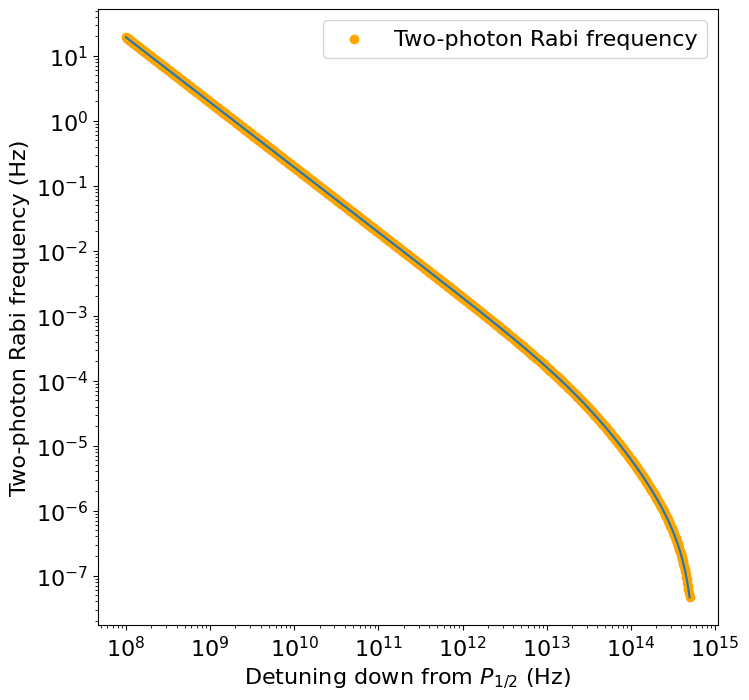

In [ ]:
from scipy.interpolate import interp1d

Omega_tilde = []

for i in detunings:
    beam1.set_laser_freq([lambda_transition['P12_S12'], i])
    beam2.set_laser_freq([lambda_transition['P12_S12'], i])
    Omega_tilde.append(-(omega_transition['P12_S12']-2*np.pi*i)/omega_transition['P12_S12']*two_photon_Rabi('S12', -0.5, beam1, beam2)/(beam1.E)/(beam2.E))

Omega_tilde = np.array(Omega_tilde)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(detunings, Omega_tilde, color='orange', label='Two-photon Rabi frequency')

detuning_interpolated = interp1d(Omega_tilde, detunings, kind='cubic', fill_value='extrapolate')
ax.plot(detuning_interpolated(Omega_tilde), Omega_tilde)

ax.set_yscale('log')
ax.set_xscale('log')

ax.tick_params(labelsize=16)
ax.set_xlabel(r'Detuning down from $P_{1/2}$ (Hz)', fontsize=16)
ax.set_ylabel('Two-photon Rabi frequency (Hz)', fontsize=16)
ax.legend(fontsize=16)

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

Text(0, 0.5, 'Raman scattering rate')

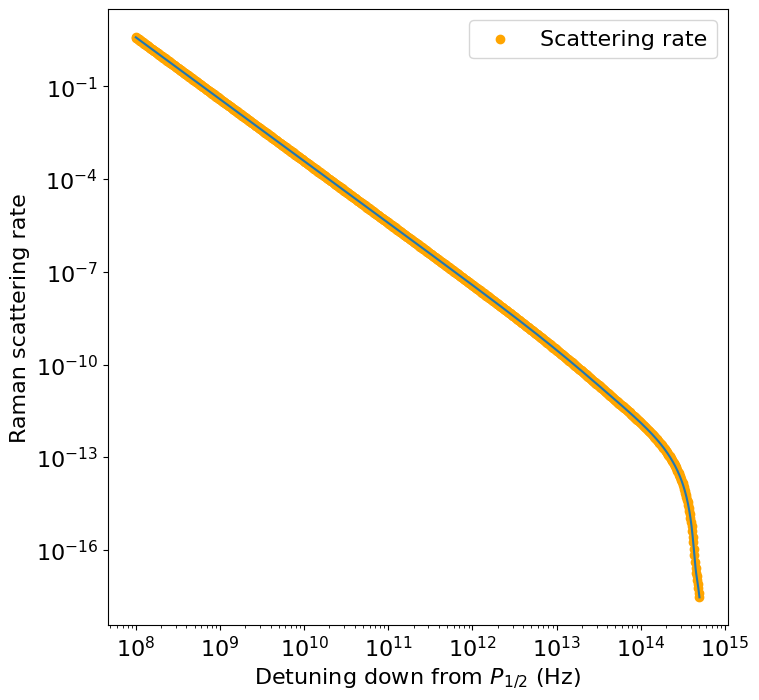

In [ ]:
from scipy.interpolate import interp1d

Gamma_inelastic = np.array([Gamma_inelastic_calc(detunings[i]) for i in tqdm(range(detunings.shape[0]))])
Gamma_elastic = np.array([Gamma_elastic_calc(detunings[i]) for i in tqdm(range(detunings.shape[0]))])

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(detunings, Gamma_inelastic + Gamma_elastic, color='orange', label='Scattering rate')

Gamma_qubit_interpolated = interp1d(detunings, Gamma_inelastic + Gamma_elastic, kind='cubic', fill_value='extrapolate')
ax.plot(detunings, Gamma_qubit_interpolated(detunings))

ax.set_yscale('log')
ax.set_xscale('log')

ax.tick_params(labelsize=16)
ax.set_xlabel(r'Detuning down from $P_{1/2}$ (Hz)', fontsize=16)
ax.legend(fontsize=16)
ax.set_ylabel('Raman scattering rate', fontsize=16)

  0%|          | 0/1001 [00:00<?, ?it/s]

Text(0, 0.5, 'Recoil rate')

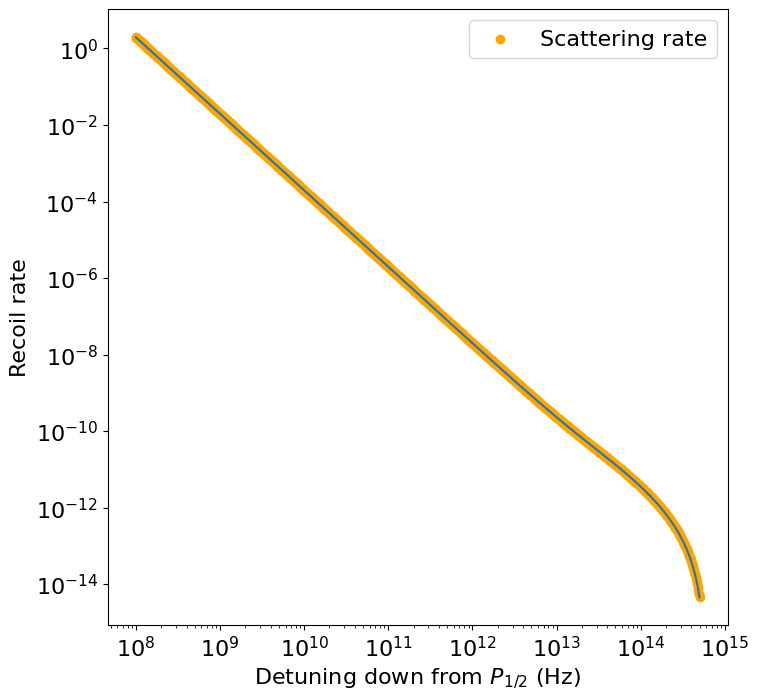

In [ ]:
Gamma_recoil = np.array([Gamma_rec_calc(detunings[i]) for i in tqdm(range(detunings.shape[0]))])

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(detunings, Gamma_recoil, color='orange', label='Scattering rate')

Gamma_recoil_interpolated = interp1d(detunings, Gamma_recoil, kind='cubic', fill_value='extrapolate')
ax.plot(detunings, Gamma_recoil_interpolated(detunings))

ax.set_yscale('log')
ax.set_xscale('log')

ax.tick_params(labelsize=16)
ax.set_xlabel(r'Detuning down from $P_{1/2}$ (Hz)', fontsize=16)
ax.legend(fontsize=16)
ax.set_ylabel('Recoil rate', fontsize=16)

### Writing lookup tables to file

In [ ]:
file_name = Path(f'{data_storage_path}\\lookup_table_{atom}.txt')
with open(file_name, 'w') as f:
    f.write("# Detuning (W), Normalized two-photon Rabi, Normalized Inelastic scatter rate, Normalized Recoil rate\n")
    for i in range(len(detunings)):
        f.write(f"{detunings[i]}, {Omega_tilde[i]}, {Gamma_inelastic[i] + Gamma_elastic[i]}, {Gamma_recoil[i]}\n")

### Loading lookup tables from file

In [ ]:
from scipy.interpolate import interp1d

data_lookup = np.loadtxt(Path(f'{data_storage_path}\\lookup_table_{atom}.txt'), skiprows=1, delimiter=',')
detuning_interpolated = interp1d(data_lookup[:,1], data_lookup[:,0], kind='cubic', fill_value='extrapolate')
Gamma_qubit_interpolated = interp1d(data_lookup[:,0], data_lookup[:,2], kind='cubic', fill_value='extrapolate')
Gamma_recoil_interpolated = interp1d(data_lookup[:,0], data_lookup[:,3], kind='cubic', fill_value='extrapolate')

### Calculating optimal scattering error v/s total laser power (all configurations)

In [ ]:
sw_coeff = (0.5*omega_y_s/omega_y_c + 0.75)*eta_y_s*eta_y_s

print((sw_coeff))
print(np.sqrt(sw_coeff)/(1+np.sqrt(sw_coeff)))

0.0045869508685663475
0.06343103621528384


In [64]:
log_powers = np.linspace(np.log10(1E-7), np.log10(1E2), 5001)
powers = 10**log_powers
E_0_sq_g = 4*powers/(np.pi*epsilon_0*c*expt_params['w_g_tr']*expt_params['w_g_ax'])
E_0_sq_sw = 4*powers/(np.pi*epsilon_0*c*expt_params['w_sw_tr']*expt_params['w_sw_ax'])

In [ ]:
# SW scheme
def detuning_sw_func(p, E_sq):
    return detuning_interpolated(2*np.sqrt(2)*np.pi / (t_gate * eta_y_s * E_sq * np.sqrt(p*(1.0-p))))

def cost_func(p, E_sq, switch_qubit=1, switch_recoil=1):
    Delta = detuning_interpolated(2*np.sqrt(2)*np.pi / (t_gate * eta_y_s * E_sq * np.sqrt(p*(1.0-p)))) 

    eta_correction = (omega_transition['P12_S12']-2*np.pi*Delta)/omega_transition['P12_S12']
    #Gamma_qub = (Gamma_inelastic_calc(Delta) + Gamma_elastic_calc(Delta)) * switch_qubit
    Gamma_qub = Gamma_qubit_interpolated(Delta) * switch_qubit
    #Gamma_rec = Gamma_rec_calc(Delta) * switch_recoil 
    Gamma_rec = Gamma_recoil_interpolated(Delta) * switch_recoil
    return (p*(Gamma_qub + eta_y_s**2*Gamma_rec*(1.0/12)) + (1-p)*(sw_coeff*eta_correction**2*Gamma_qub + eta_correction**2*eta_y_s**2*Gamma_rec*(1.0/4)))*E_sq*t_gate/2

# TW scheme
def detuning_tw_func(E_sq):
    return detuning_interpolated(2*np.sqrt(2)*np.pi / (t_gate * eta_y_s * E_sq * 0.5))

def scattering_error_tw_func(E_sq, switch_qubit=1, switch_recoil=1):
    Delta = detuning_interpolated(2*np.sqrt(2)*np.pi / (t_gate * eta_y_s * E_sq * 0.5))

    eta_correction = (omega_transition['P12_S12']-2*np.pi*Delta)/omega_transition['P12_S12']
    Gamma_qub = Gamma_qubit_interpolated(Delta) * switch_qubit
    Gamma_rec = Gamma_recoil_interpolated(Delta) * switch_recoil

    return E_sq*(Gamma_qub + eta_y_s**2*Gamma_rec*(1.0/12)*(1+np.sqrt(1.5)*eta_correction/2)**2)*t_gate/2

# TW scheme (fair)
def detuning_tw_fair_func(E_sq):
    return detuning_interpolated(2*np.sqrt(2)*np.pi / (t_gate * eta_y_s * E_sq * 0.5 / np.sqrt(2)))

def scattering_error_tw_fair_func(E_sq, switch_qubit=1, switch_recoil=1):
    Delta = detuning_interpolated(2*np.sqrt(2)*np.pi / (t_gate * eta_y_s * E_sq * 0.5 / np.sqrt(2)))
    
    eta_correction = (omega_transition['P12_S12']-2*np.pi*Delta)/omega_transition['P12_S12']
    Gamma_qub = Gamma_qubit_interpolated(Delta) * switch_qubit
    Gamma_rec = Gamma_recoil_interpolated(Delta) * switch_recoil

    return E_sq*(Gamma_qub + eta_y_s**2*Gamma_rec*(1.0/24)*(1+(1+np.sqrt(3)*eta_correction/2)**2))*t_gate/2

In [ ]:
# SW scheme
optimal_power_ratio = []
optimal_detuning = []
optimal_scattering_error_sw = []
optimal_scattering_error_sw_qubit = []
optimal_scattering_error_sw_recoil = []
scattering_error_enhancement_from_unequal_power_dist = []

# TW scheme
detuning_tw = []
scattering_error_tw = []
scattering_error_tw_qubit = []
scattering_error_tw_recoil = []

# TW scheme (fair)
detuning_tw_fair = []
scattering_error_tw_fair = []
scattering_error_tw_fair_qubit = []
scattering_error_tw_fair_recoil = []

for i in tqdm(range(log_powers.shape[0])):
    E_sq_g = E_0_sq_g[i]
    E_sq_sw = E_0_sq_sw[i]

    x0 = np.sqrt(sw_coeff)/(1+np.sqrt(sw_coeff))

    result = opt.minimize(cost_func, x0, args=E_sq_sw, method='Nelder-Mead', bounds=[(0.00001,1)])
    
    # SW
    optimal_power_ratio.append(result.x[0])
    optimal_detuning.append(detuning_sw_func(result.x[0], E_sq_sw))
    optimal_scattering_error_sw_qubit.append(cost_func(result.x[0], E_sq_sw, switch_qubit=1, switch_recoil=0))
    optimal_scattering_error_sw_recoil.append(cost_func(result.x[0], E_sq_sw, switch_qubit=0, switch_recoil=1))
    optimal_scattering_error_sw.append(result.fun)
    scattering_error_enhancement_from_unequal_power_dist.append(cost_func(0.5, E_sq_sw)/cost_func(result.x[0], E_sq_sw))

    # TW
    detuning_tw.append(detuning_tw_func(E_sq_g))
    scattering_error_tw.append(scattering_error_tw_func(E_sq_g))
    scattering_error_tw_qubit.append(scattering_error_tw_func(E_sq_g, switch_qubit=1, switch_recoil=0))
    scattering_error_tw_recoil.append(scattering_error_tw_func(E_sq_g, switch_qubit=0, switch_recoil=1))

    # TW (fair)
    detuning_tw_fair.append(detuning_tw_fair_func(E_sq_sw))
    scattering_error_tw_fair.append(scattering_error_tw_fair_func(E_sq_sw))
    scattering_error_tw_fair_qubit.append(scattering_error_tw_fair_func(E_sq_sw, switch_qubit=1, switch_recoil=0))
    scattering_error_tw_fair_recoil.append(scattering_error_tw_fair_func(E_sq_sw, switch_qubit=0, switch_recoil=1))

optimal_power_ratio = np.array(optimal_power_ratio)
optimal_detuning = np.array(optimal_detuning)
optimal_scattering_error_sw = np.array(optimal_scattering_error_sw)
optimal_scattering_error_sw_qubit = np.array(optimal_scattering_error_sw_qubit)
optimal_scattering_error_sw_recoil = np.array(optimal_scattering_error_sw_recoil)
scattering_error_enhancement_from_unequal_power_dist = np.array(scattering_error_enhancement_from_unequal_power_dist)

detuning_tw = np.array(detuning_tw)
scattering_error_tw = np.array(scattering_error_tw)
scattering_error_tw_qubit = np.array(scattering_error_tw_qubit)
scattering_error_tw_recoil = np.array(scattering_error_tw_recoil)

detuning_tw_fair = np.array(detuning_tw_fair)
scattering_error_tw_fair = np.array(scattering_error_tw_fair)
scattering_error_tw_fair_qubit = np.array(scattering_error_tw_fair_qubit)
scattering_error_tw_fair_recoil = np.array(scattering_error_tw_fair_recoil)

  0%|          | 0/5001 [00:00<?, ?it/s]

C:\Users\Aditya\AppData\Local\Temp\ipykernel_8792\340406123.py:6: RuntimeWarning: divide by zero encountered in divide
  Delta = detuning_interpolated(2*np.sqrt(2)*np.pi / (t_gate * eta_y_s * E_sq * np.sqrt(p*(1.0-p))))


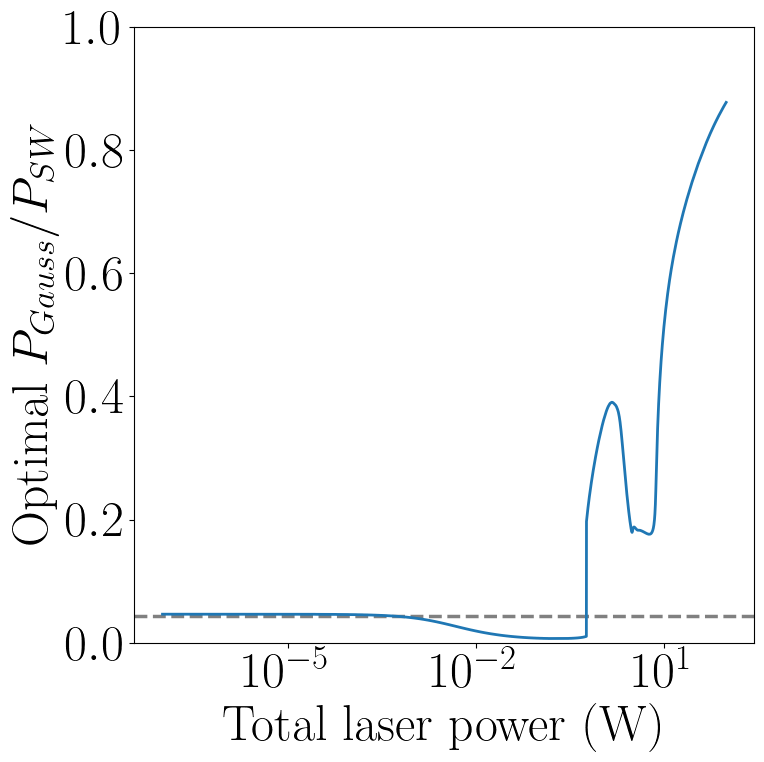

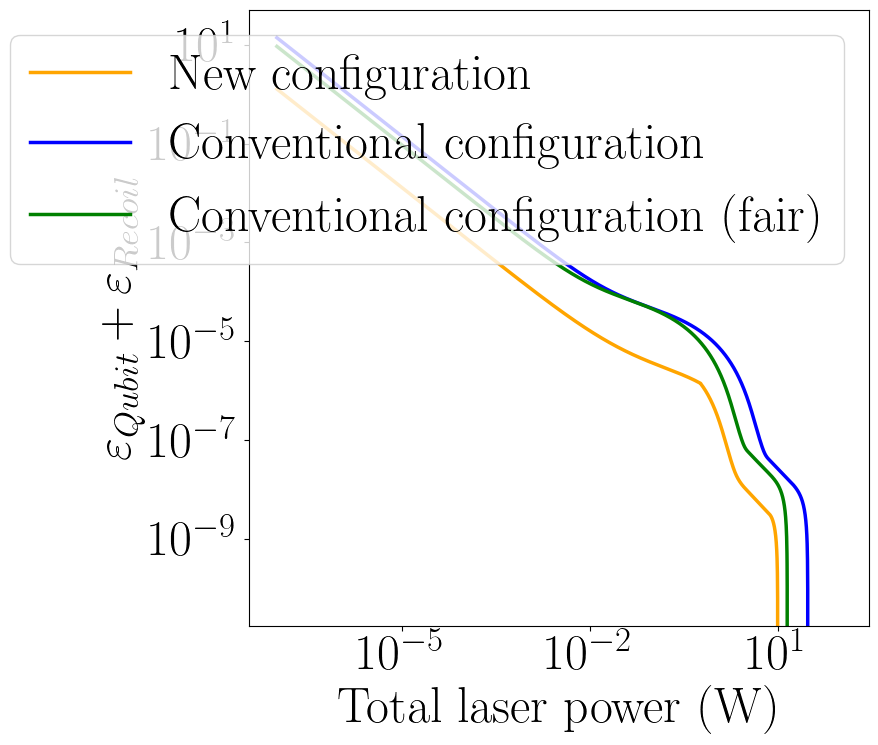

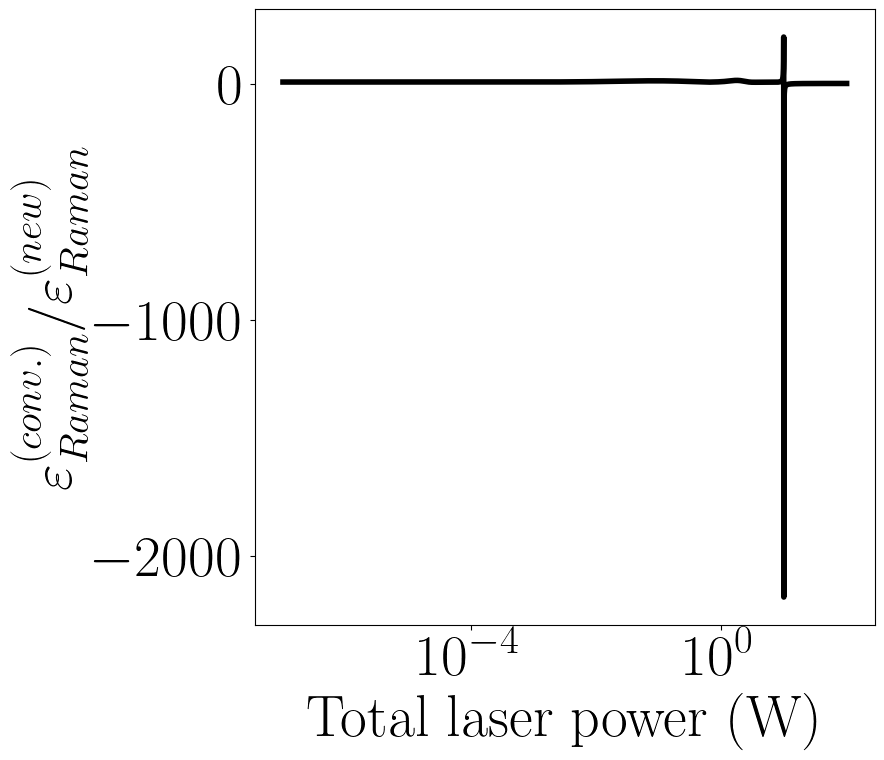

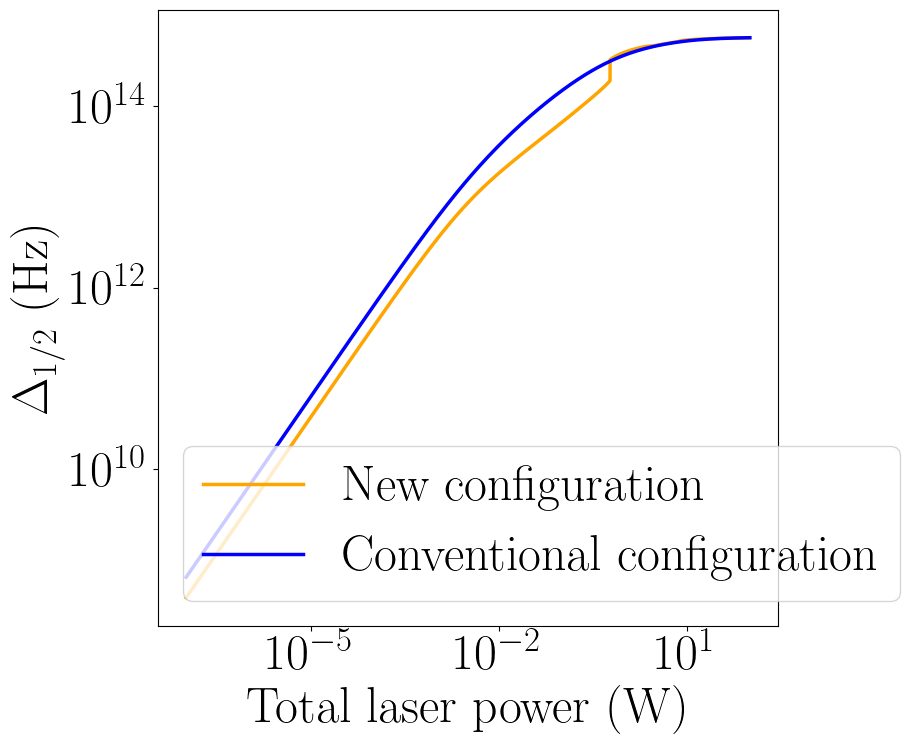

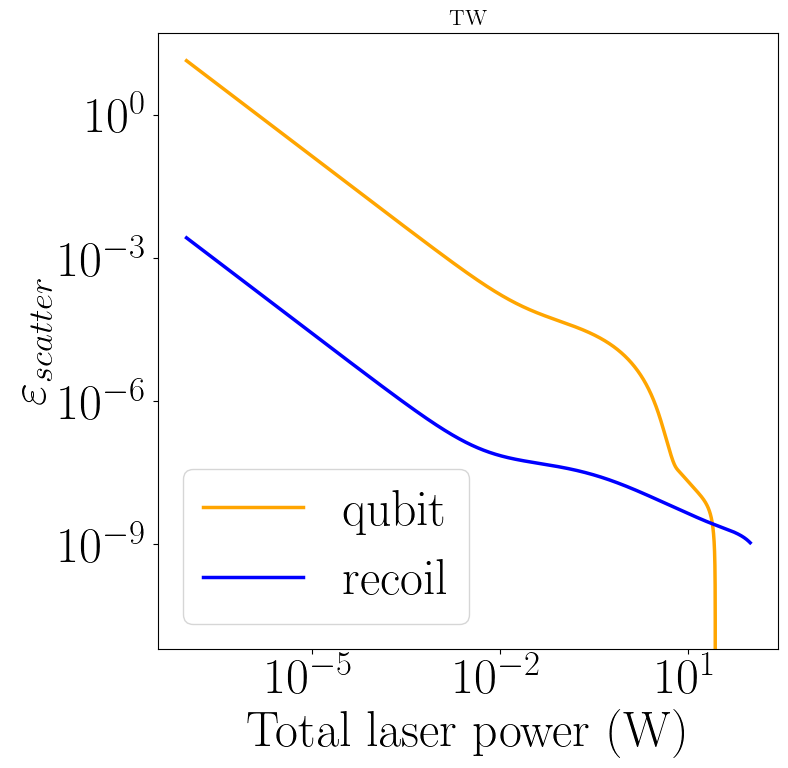

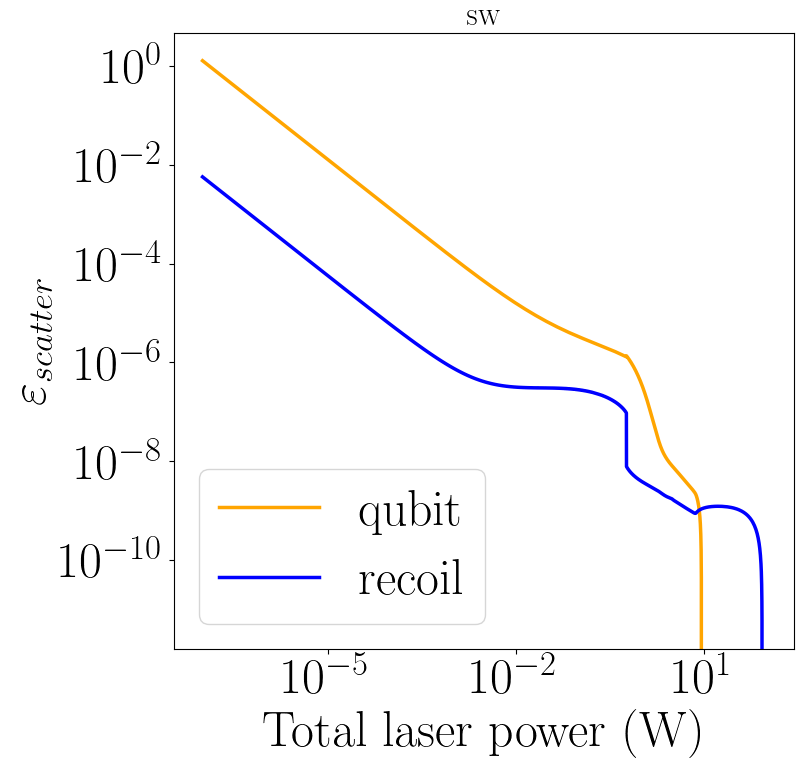

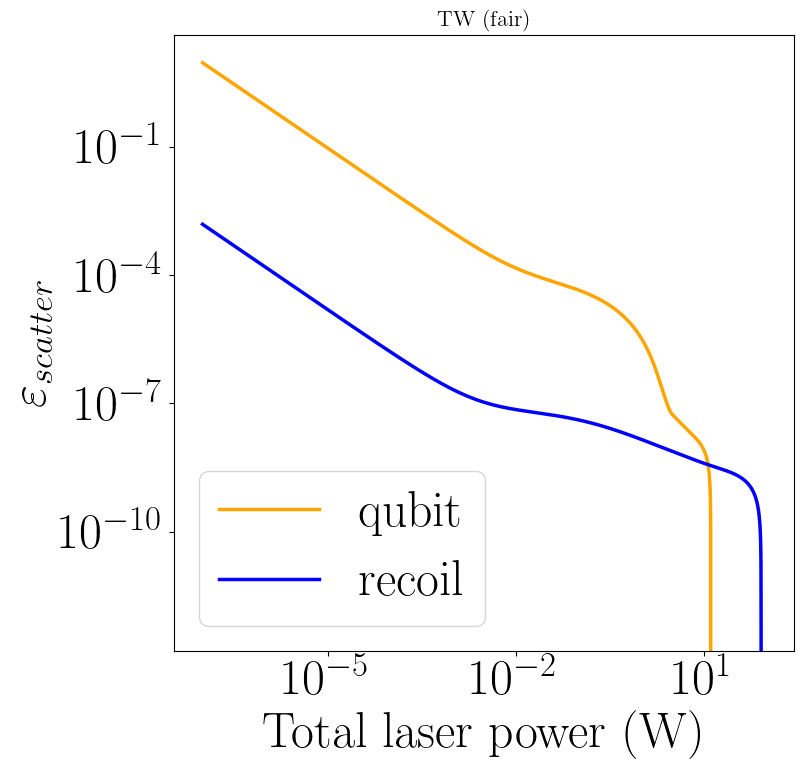

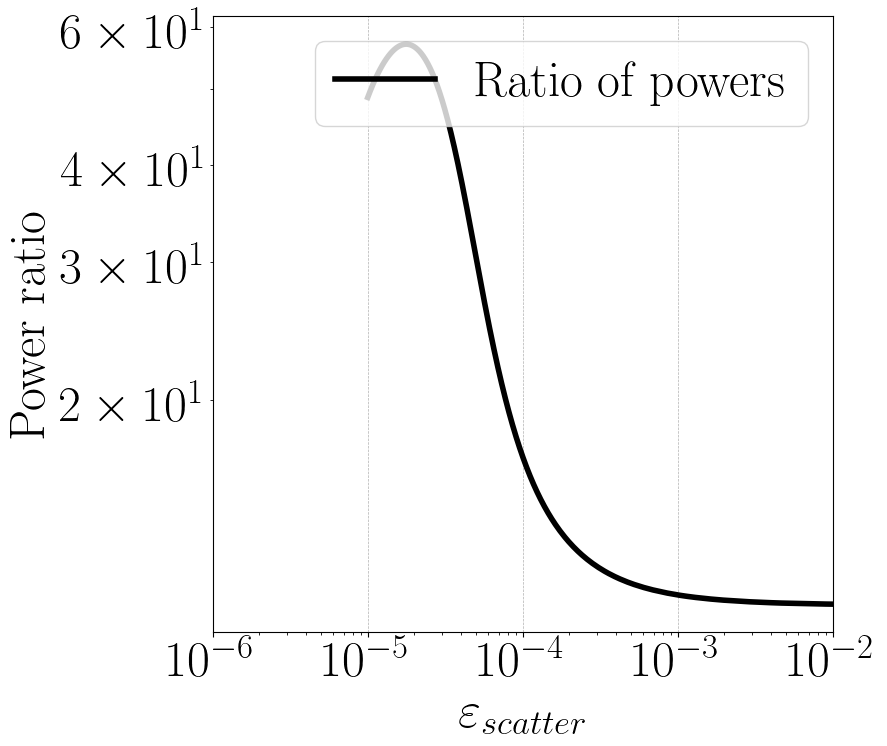

In [ ]:
# Single species plots
from scipy.interpolate import interp1d
from matplotlib.ticker import FixedLocator, LogFormatterMathtext

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.axhline(y=np.sqrt(sw_coeff)/(1+np.sqrt(sw_coeff)), color='gray', linestyle='--')
ax.plot(powers, optimal_power_ratio, linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Total laser power (W)')
ax.set_ylim(0, 1.0)
ax.set_ylabel(r'Optimal $P_{Gauss}/P_{SW}$')

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(powers, optimal_scattering_error_sw, color='orange', label='New configuration')
ax.plot(powers, scattering_error_tw, color='blue', label='Conventional configuration')
ax.plot(powers, scattering_error_tw_fair, color='green', label='Conventional configuration (fair)')
ax.set_xscale('log')
ax.set_xlabel('Total laser power (W)')
ax.set_ylabel(r'$\varepsilon_{Qubit}+\varepsilon_{Recoil}$')
ax.set_yscale('log')
ax.legend(loc='upper right')

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(powers, scattering_error_tw_fair/optimal_scattering_error_sw, color='black', linewidth=4)
ax.set_xlabel('Total laser power (W)', fontsize=42)
ax.set_ylabel(r'$\varepsilon^{(conv.)}_{Raman}/\varepsilon^{(new)}_{Raman}$', fontsize=42)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.tick_params(axis='both', which='major', labelsize=42)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(powers, optimal_detuning, color='orange', label='New configuration')
ax.plot(powers, detuning_tw_fair, color='blue', label='Conventional configuration')
ax.set_xscale('log')
ax.set_xlabel('Total laser power (W)')
ax.set_ylabel(r'$\Delta_{1/2}$ (Hz)')
ax.set_yscale('log')
ax.legend()

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(powers, scattering_error_tw_qubit, color='orange', label='qubit')
ax.plot(powers, scattering_error_tw_recoil, color='blue', label='recoil')
ax.set_xscale('log')
ax.set_xlabel('Total laser power (W)')
ax.set_ylabel(r'$\varepsilon_{scatter}$')
ax.set_yscale('log')
ax.legend(loc='lower left')
ax.set_title('TW', fontsize=16)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(powers, optimal_scattering_error_sw_qubit, color='orange', label='qubit')
ax.plot(powers, optimal_scattering_error_sw_recoil, color='blue', label='recoil')
ax.set_xscale('log')
ax.set_xlabel('Total laser power (W)')
ax.set_ylabel(r'$\varepsilon_{scatter}$')
ax.set_yscale('log')
ax.legend(loc='lower left')
ax.set_title('SW', fontsize=16)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(powers, scattering_error_tw_fair_qubit, color='orange', label='qubit')
ax.plot(powers, scattering_error_tw_fair_recoil, color='blue', label='recoil')
ax.set_xscale('log')
ax.set_xlabel('Total laser power (W)')
ax.set_ylabel(r'$\varepsilon_{scatter}$')
ax.set_yscale('log')
ax.legend(loc='lower left')
ax.set_title('TW (fair)', fontsize=16)

power_sw_interpolated = interp1d(optimal_scattering_error_sw, 1000*np.array(powers), kind='linear', fill_value='extrapolate')
power_tw_interpolated = interp1d(scattering_error_tw, 1000*np.array(powers), kind='linear', fill_value='extrapolate')
power_tw_fair_interpolated = interp1d(scattering_error_tw_fair, 1000*np.array(powers), kind='linear', fill_value='extrapolate')
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(np.linspace(1E-5,1E-2, 50000), power_tw_interpolated(np.linspace(1E-5,1E-2, 50000))/power_sw_interpolated(np.linspace(1E-5,1E-2, 50000)), color='black', linewidth=4, label='Ratio of powers')
ax.set_yscale('log')
ax.set_ylabel('Power ratio')
ax.set_xlabel(r'$\varepsilon_{scatter}$')
ax.set_xscale('log')
ax.set_xlim(1E-6, 1E-2)
ax.legend(loc='upper right')
ax.grid(True, which='major', linestyle='--', linewidth=0.5)

### Writing results to file

In [ ]:
file_name = Path(f'{data_storage_path}\\scattering_data_LS_{atom}.txt')
with open(file_name, 'w') as f:
    f.write("# Power (W), Optimal Power Ratio, Optimal Detuning SW (Hz), Enhancement from unequal powers, Optimal Scattering Error SW, Optimal qubit SE SW, Optimal recoil SE SW, Detuning TW (Hz), Scattering Error TW, Qubit SE TW, Recoil SE TW, Detuning TW Fair (Hz), Scattering Error TW Fair, Qubit SE TW Fair, Recoil SE TW Fair\n")
    for i in range(len(log_powers)):
        f.write(f"{powers[i]}, {optimal_power_ratio[i]}, {optimal_detuning[i]}, {scattering_error_enhancement_from_unequal_power_dist[i]}, {optimal_scattering_error_sw[i]}, {optimal_scattering_error_sw_qubit[i]}, {optimal_scattering_error_sw_recoil[i]}, {detuning_tw[i]}, {scattering_error_tw[i]}, {scattering_error_tw_qubit[i]}, {scattering_error_tw_recoil[i]}, {detuning_tw_fair[i]}, {scattering_error_tw_fair[i]}, {scattering_error_tw_fair_qubit[i]}, {scattering_error_tw_fair_recoil[i]}\n")

### Generating plots

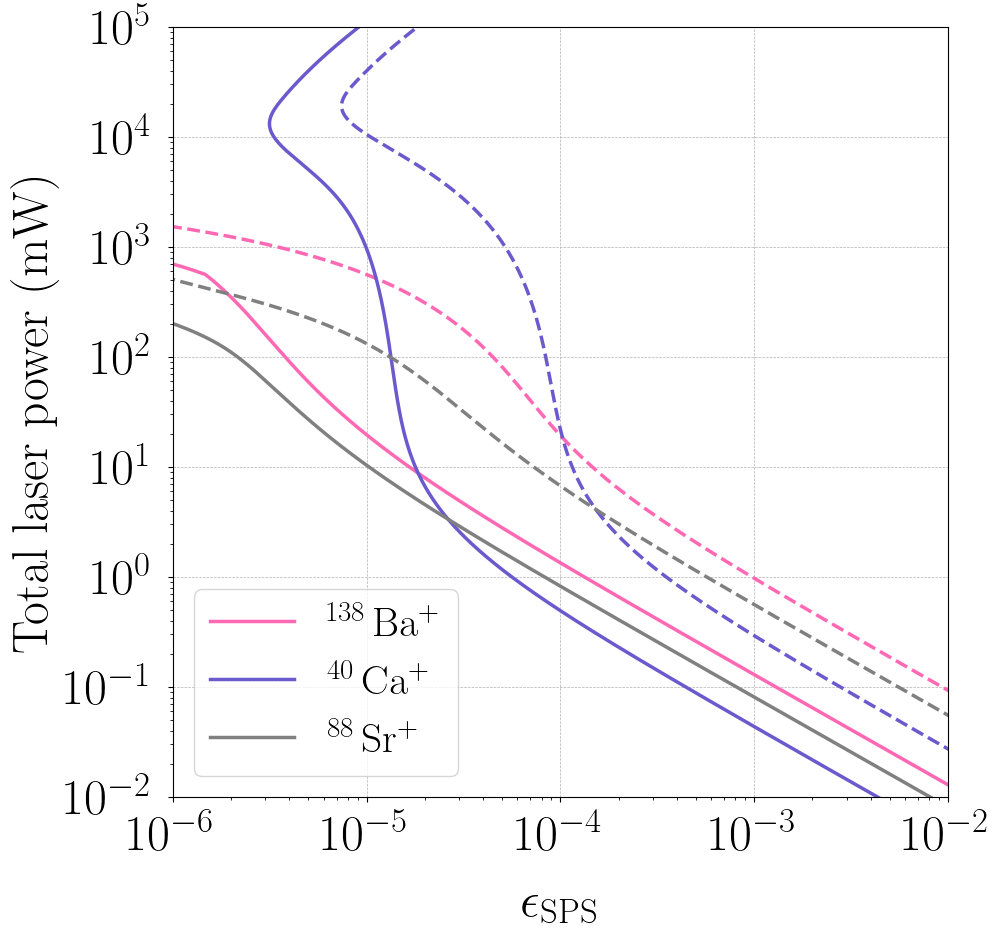

In [ ]:
# Laser power required for a given scattering error
from matplotlib import cm
import re

fig, ax = plt.subplots(1,1, figsize=(10,10))

data_files = glob.glob(f'{data_storage_path}\\scattering_data_LS_*.txt')

cmap = plt.get_cmap('Set1')
color = iter(['hotpink','slateblue','grey'])

for file in data_files:
    col = next(color)
    
    data = np.loadtxt(file, skiprows=1, delimiter=',')
    atom_label = re.search(r'scattering_data_LS_(.*).txt', file).group(1)
    element_label = atom_label.split('_')[0]
    mass_label = atom_label.split('_')[1]

    ax.plot(data[:, 4], 1000*np.array(data[:, 0]), color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
    ax.plot(data[:, 12], 1000*np.array(data[:, 0]), color=col, linestyle="--")

ax.tick_params('both', pad=10)
ax.set_yscale('log')
ax.set_ylabel('Total laser power (mW)')
ax.set_xlabel(r'$\epsilon_{\mathrm{SPS}}$', labelpad=15)
ax.set_xscale('log')
ax.set_xlim(1E-6, 1E-2)
ax.set_ylim(1E-2, 1E5)
ax.legend(loc='lower left', fontsize=30)
ax.grid(True, which='major', linestyle='--', linewidth=0.5)

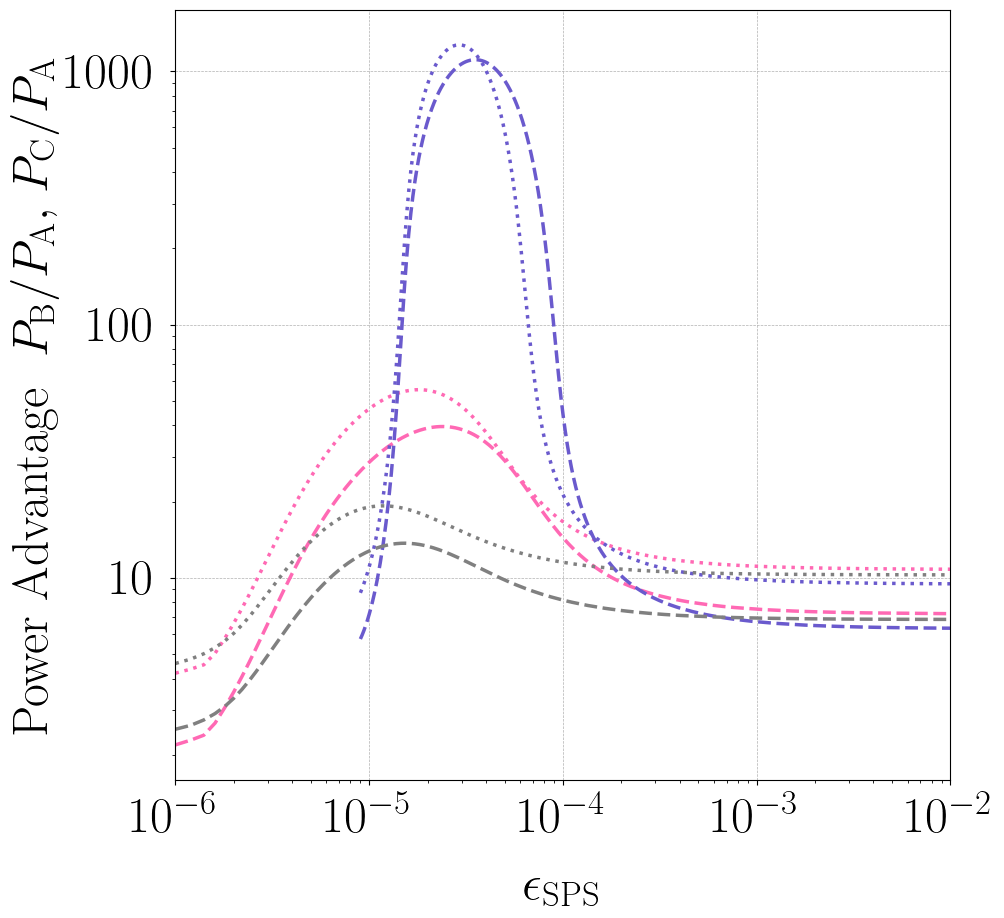

In [ ]:
# Power advantage of new scheme over conventional schemes
from scipy.interpolate import interp1d
from matplotlib.ticker import ScalarFormatter, FuncFormatter

fig, ax = plt.subplots(1,1, figsize=(10,10))

data_files = glob.glob(f'{data_storage_path}\\scattering_data_LS_*.txt')

color = iter(['hotpink','slateblue','grey'])

for file in data_files:
    col = next(color)
    
    data = np.loadtxt(file, skiprows=1, delimiter=',')
    atom_label = re.search(r'scattering_data_LS_(.*).txt', file).group(1)
    element_label = atom_label.split('_')[0]
    mass_label = atom_label.split('_')[1]

    power_sw_interpolated = interp1d(data[:-110,4], 1000*np.array(data[:-110,0]), kind='cubic', fill_value='extrapolate')
    power_tw_interpolated = interp1d(data[:-110,8], 1000*np.array(data[:-110,0]), kind='cubic', fill_value='extrapolate')
    power_tw_fair_interpolated = interp1d(data[:-110,12], 1000*np.array(data[:-110,0]), kind='linear', fill_value='extrapolate')

    if atom_label == 'Ca_40':
        ax.plot(np.linspace(9E-6,1E-2, 50000), power_tw_fair_interpolated(np.linspace(9E-6,1E-2, 50000))/power_sw_interpolated(np.linspace(8E-6,1E-2, 50000)), color=col, linestyle='--')
        ax.plot(np.linspace(9E-6,1E-2, 50000), power_tw_interpolated(np.linspace(9E-6,1E-2, 50000))/power_sw_interpolated(np.linspace(8E-6,1E-2, 50000)), color=col, linestyle=':')
        ax.plot(np.linspace(9E-6,1E-2, 50000), -power_tw_interpolated(np.linspace(9E-6,1E-2, 50000))/power_sw_interpolated(np.linspace(8E-6,1E-2, 50000)), color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
    else:
        ax.plot(np.linspace(1E-6,1E-2, 50000), power_tw_fair_interpolated(np.linspace(1E-6,1E-2, 50000))/power_sw_interpolated(np.linspace(1E-6,1E-2, 50000)), color=col, linestyle='--')
        ax.plot(np.linspace(1E-6,1E-2, 50000), power_tw_interpolated(np.linspace(1E-6,1E-2, 50000))/power_sw_interpolated(np.linspace(1E-6,1E-2, 50000)), color=col, linestyle=':')
        ax.plot(np.linspace(1E-6,1E-2, 50000), -power_tw_interpolated(np.linspace(1E-6,1E-2, 50000))/power_sw_interpolated(np.linspace(1E-6,1E-2, 50000)), color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
    
ax.tick_params('both', pad=10)
ax.set_yscale('log')
ax.set_ylabel(r'Power Advantage $\,\,P_{\mathrm{B}}/P_{\mathrm{A}},$ $P_{\mathrm{C}}/P_{\mathrm{A}}$')
ax.set_xlabel(r'$\epsilon_{\mathrm{SPS}}$', labelpad=15)
ax.set_xscale('log')
ax.set_xlim(1E-6, 1E-2)
ax.grid(True, which='major', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

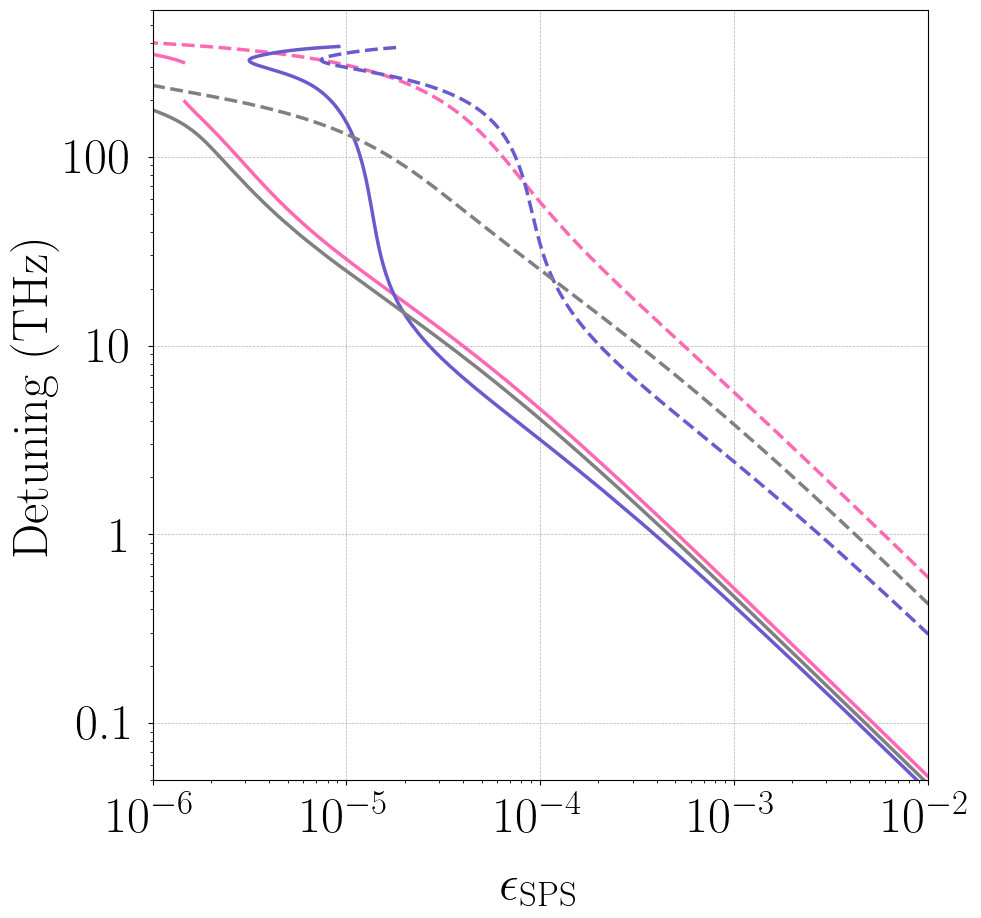

In [ ]:
# Detuning required for a given scattering error
from scipy.interpolate import interp1d
from matplotlib.ticker import ScalarFormatter, FuncFormatter

fig, ax = plt.subplots(1,1, figsize=(10,10))

data_files = glob.glob(f'{data_storage_path}\\scattering_data_LS_*.txt')

color = iter(['hotpink','slateblue','grey'])

for file in data_files:
    col = next(color)
    
    data = np.loadtxt(file, skiprows=1, delimiter=',')
    atom_label = re.search(r'scattering_data_LS_(.*).txt', file).group(1)
    element_label = atom_label.split('_')[0]
    mass_label = atom_label.split('_')[1]

    if atom_label == 'Ba_138':
        ax.plot(data[:-500,4],data[:-500,2]/1E12, color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
        ax.plot(data[1501:,4],data[1501:,2]/1E12, color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
    else:
        ax.plot(data[:,4],data[:,2]/1E12, color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
    ax.plot(data[:,12],data[:,11]/1E12, color=col, linestyle='--')
    
ax.tick_params('both', pad=10)
ax.set_yscale('log')
ax.set_ylabel(r'Detuning (THz)')
ax.set_xlabel(r'$\epsilon_{\mathrm{SPS}}$', labelpad=15)
ax.set_xscale('log')
ax.set_xlim(1E-6, 1E-2)
ax.set_ylim(5E10/1E12, 6E14/1E12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

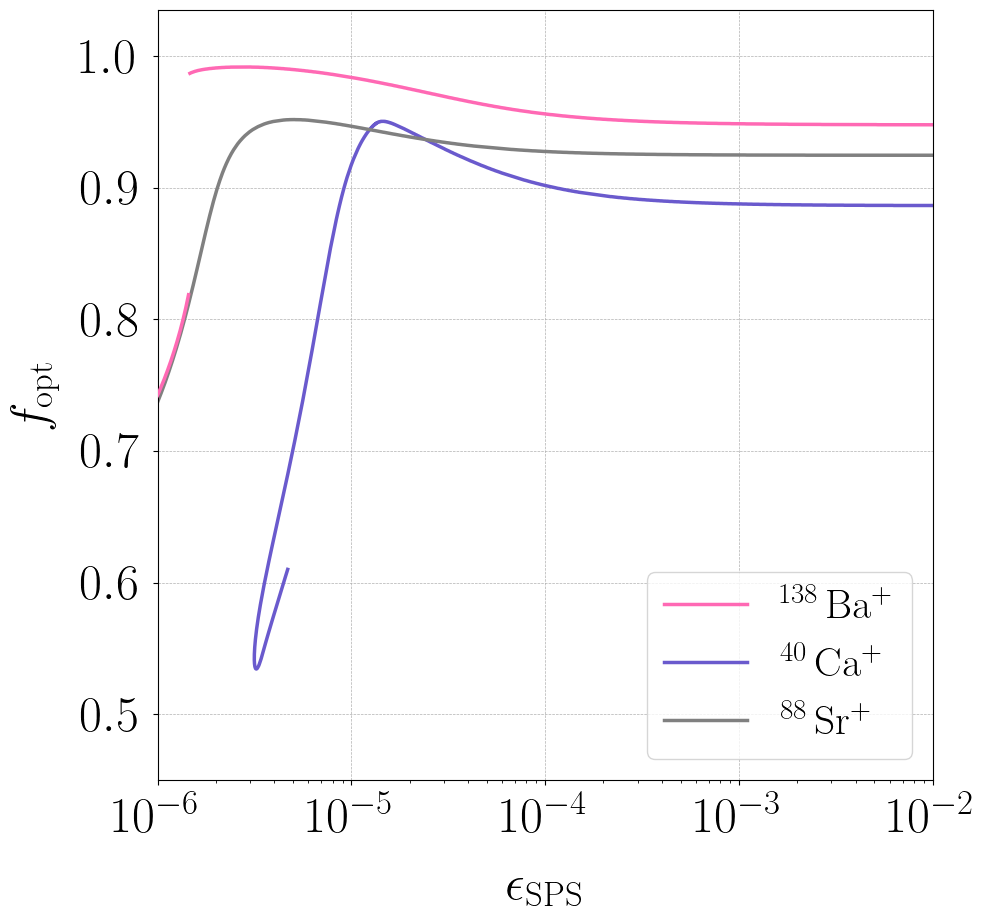

In [ ]:
# Optimal power distribution between SW and RW in the 'SW scheme' 
from scipy.interpolate import interp1d
from matplotlib.ticker import ScalarFormatter, FuncFormatter

fig, ax = plt.subplots(1,1, figsize=(10,10))

data_files = glob.glob(f'{data_storage_path}\\scattering_data_LS_*.txt')

color = iter(['hotpink','slateblue','grey'])

for file in data_files:
    col = next(color)
    
    data = np.loadtxt(file, skiprows=1, delimiter=',')
    atom_label = re.search(r'scattering_data_LS_(.*).txt', file).group(1)
    element_label = atom_label.split('_')[0]
    mass_label = atom_label.split('_')[1]

    if atom_label == 'Ca_40':
        ax.plot(data[:-100,4],1-data[:-100,1], color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
    elif atom_label =='Sr_88':
        ax.plot(data[:,4],1-data[:,1], color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
    else:
        ax.plot(data[:-500,4],1-data[:-500,1], color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
        ax.plot(data[1501:,4],1-data[1501:,1], color=col, zorder=3)

ax.tick_params(axis='both', which='major', pad=10)
ax.set_ylabel(r'$f_{\mathrm{opt}}$', labelpad=15)
ax.set_xlabel(r'$\epsilon_{\mathrm{SPS}}$', labelpad=15)
ax.set_xscale('log')
ax.set_xlim(1E-6, 1E-2)
ax.set_ylim(bottom=0.45)
ax.legend(loc='lower right', fontsize=30)
ax.grid(True, which='major', linestyle='--', linewidth=0.5)

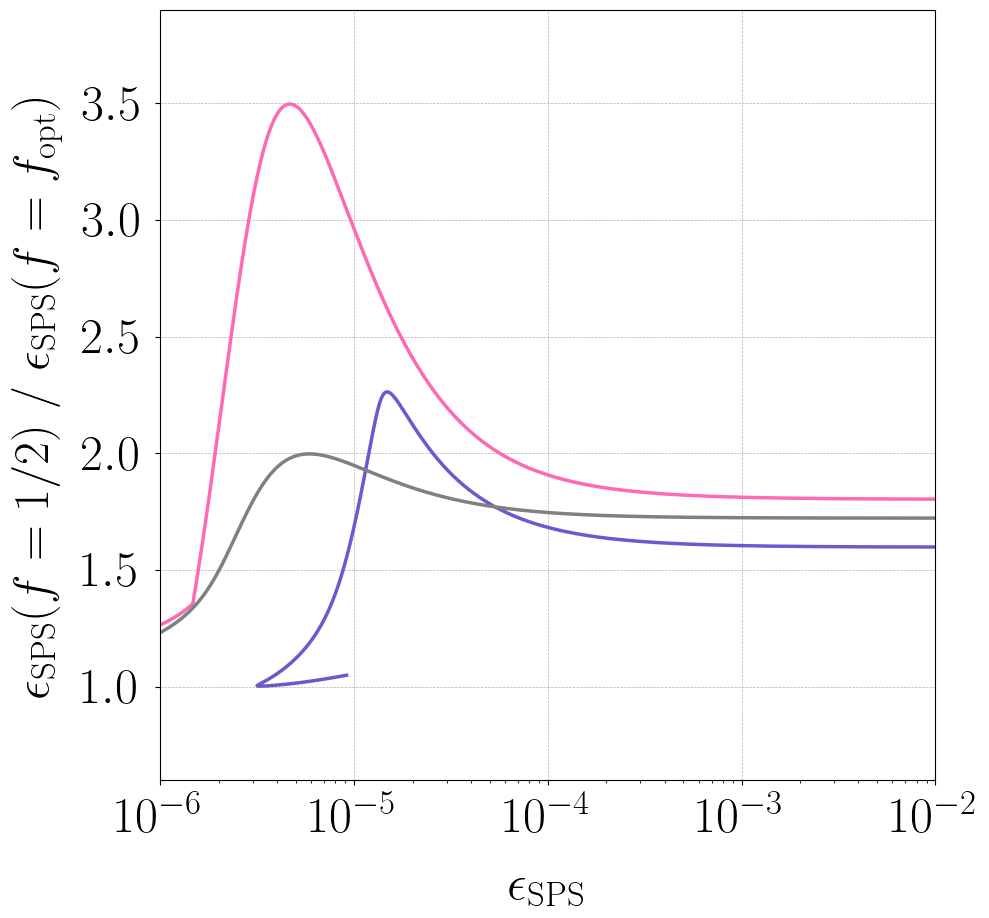

In [ ]:
# Excess scattering error from using equal power distribution between SW and RW in the 'SW scheme'
from matplotlib import cm
import re

fig, ax = plt.subplots(1,1, figsize=(10,10))

data_files = glob.glob(f'{data_storage_path}\\scattering_data_LS_*.txt')

color = iter(['hotpink','slateblue','grey'])

for file in data_files:
    col = next(color)
    data = np.loadtxt(file, skiprows=1, delimiter=',')
    atom_label = re.search(r'scattering_data_LS_(.*).txt', file).group(1)
    element_label = atom_label.split('_')[0]
    mass_label = atom_label.split('_')[1]

    ax.plot(data[:,4], data[:,3], color=col, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))

ax.tick_params(axis='both', which='major', pad=10)
ax.set_xlim(1E-6, 1E-2)
ax.set_ylim(0.6,3.9)
ax.set_xlabel(r'$\epsilon_{\mathrm{SPS}}$', labelpad=15)
ax.set_ylabel(r'$\epsilon_{\mathrm{SPS}}(f=1/2)$ / $\epsilon_{\mathrm{SPS}}(f=f_{\mathrm{opt}})$', labelpad=15)
ax.set_xscale('log')
ax.grid(True, which='major', linestyle='--', linewidth=0.5)

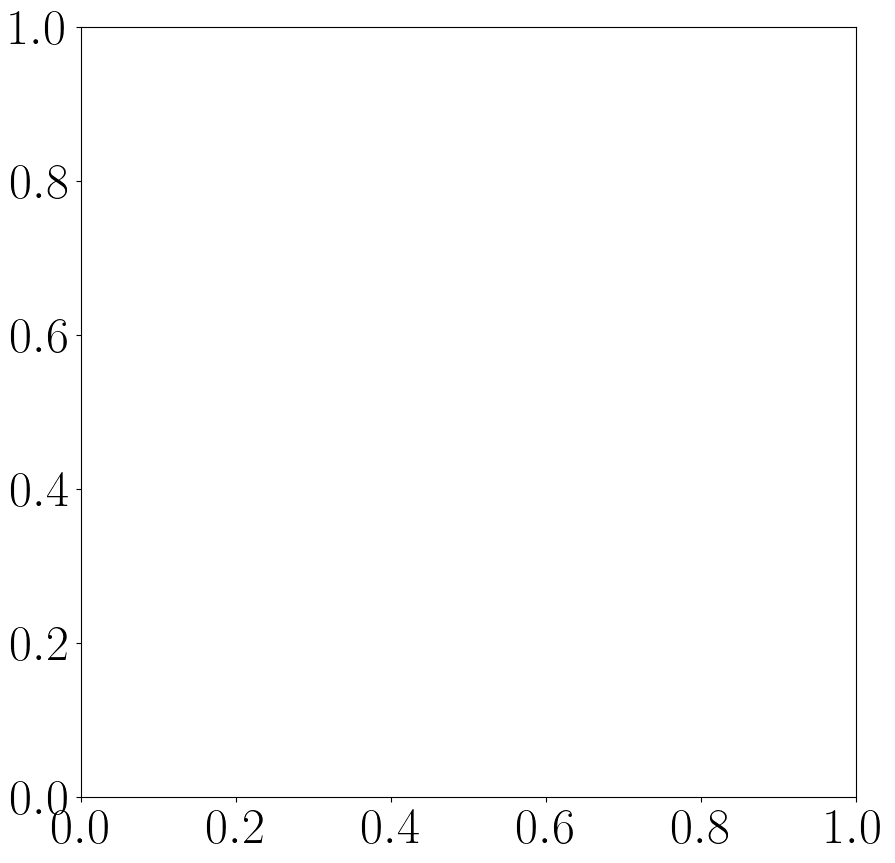

In [ ]:
# Break-down of scattering error into qubit and recoil contributions
from matplotlib import cm
import re

fig, ax = plt.subplots(1,1, figsize=(10,10))

data_files = glob.glob(f'{data_storage_path}\\scattering_data_LS_*.txt')

color = iter(['hotpink','slateblue','grey'])

count = 0
for file in data_files:
    col = next(color)
    data = np.loadtxt(file, skiprows=1, delimiter=',')
    atom_label = re.search(r'scattering_data_LS_(.*).txt', file).group(1)

    ax.plot(1000*data[:,0], data[:,5], color=col, linestyle='-', linewidth=4)
    ax.plot(1000*data[:,0], data[:,6], color=col, linestyle='-', linewidth=2)
    ax.plot(1000*data[:,0], data[:,13], color=col, linestyle='--', linewidth=4)
    ax.plot(1000*data[:,0], data[:,14], color=col, linestyle='--', linewidth=2)
    ax.plot(1000*data[:,0], -data[:,14], color=col, linestyle='-', label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=atom_label.split('_')[0], mass_label=atom_label.split('_')[1]))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1E-6, 1E-2)
    ax.set_xlim(1E-2, 1E5)
    ax.tick_params(axis='both', which='major', pad=5)
    ax.set_xlabel('Total laser power (mW)', labelpad=10)
    if count == 0:
        ax.set_ylabel(r'$\epsilon_{\mathrm{qubit}},\epsilon_{\mathrm{recoil}}$', labelpad=20)
    ax.legend(loc='upper right')
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    count = count + 1
    #plt.savefig(f'{data_storage_path}\\LS_qubit_plus_recoil_{atom_label}.pdf', bbox_inches='tight')
    ax.clear()

In [ ]:
# Excess error due to ion positioning inaccuracy
import re

def scattering_error_sw_additional_positioning_func(p, E_sq, switch_qubit=1, switch_recoil=1):
    Delta = detuning_interpolated(2*np.sqrt(2)*np.pi / (t_gate * eta_y_s * E_sq * np.sqrt(p*(1.0-p)))) 
    eta_correction = (omega_transition['P12_S12']-2*np.pi*Delta)/omega_transition['P12_S12']
    
    Gamma_qub = Gamma_qubit_interpolated(Delta) * switch_qubit
    return (1-p)*((np.sqrt(2) * (2 * np.pi / lambda_transition['P12_S12']) * np.sin(np.pi/3) * eta_correction)**2)*(Gamma_qub)*E_sq*t_gate/2

data_files = glob.glob(f'{data_storage_path}\\scattering_data_LS_*.txt')
data = np.loadtxt(data_files[2], skiprows=1, delimiter=',')
print(re.search(r'scattering_data_LS_(.*).txt', data_files[2]).group(1))
index = 1610
print(f"Power = {data[index,0]:.2e} W")
print(f"E_SPS = {data[index,4]:.2e}")
print(scattering_error_sw_additional_positioning_func(data[index,1], 4*data[index,0]/(np.pi*epsilon_0*c*expt_params['w_sw_tr']*expt_params['w_sw_ax']))*1E-18)

Sr_88
Power = 7.91e-05 W
E_SPS = 1.00e-03
4.341877764293603e-06


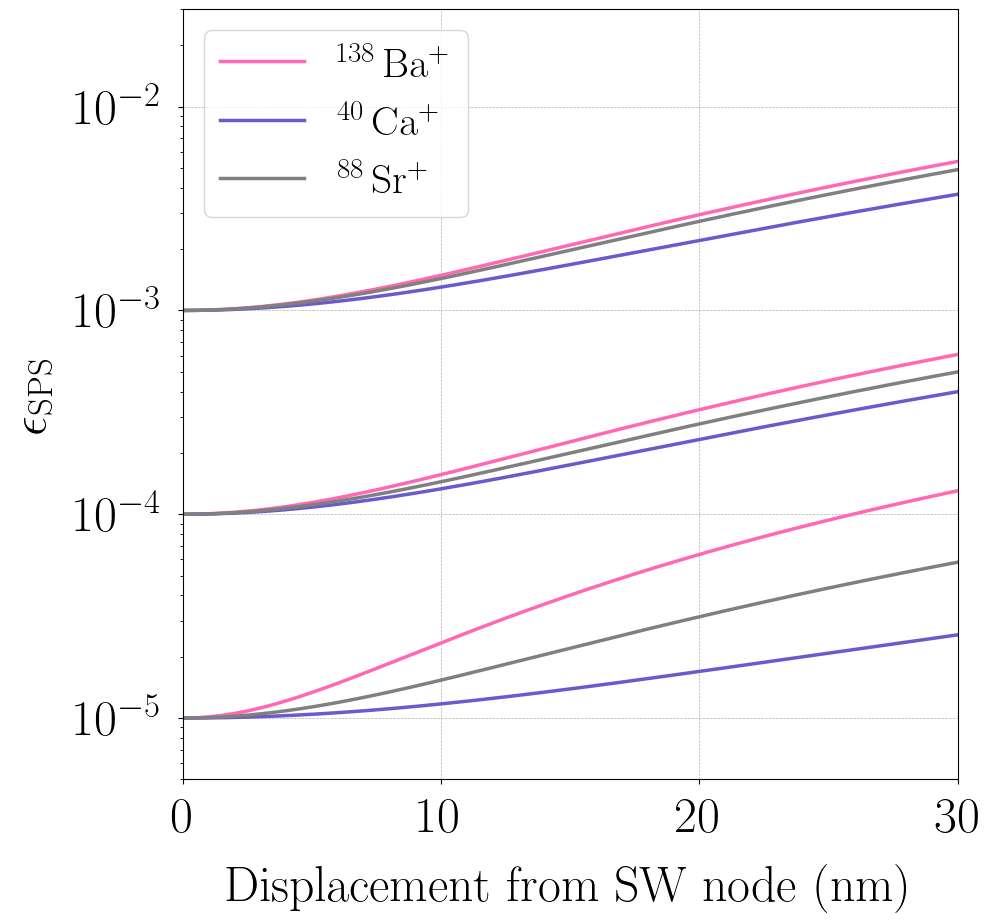

In [ ]:
from matplotlib import cm
import re

fig, ax = plt.subplots(1,1, figsize=(10,10))

data_files = glob.glob(f'{data_storage_path}\\scattering_data_LS_*.txt')

indices_2d = np.array([[2928, 3850, 2779], [2289, 2043, 2170], [1725, 1459, 1610]])
ideal_errors = [1E-5, 1E-4, 1E-3]
excess_errors = np.array([[1.3377044555105e-07, 1.7334067037329347e-08, 5.3516167778798446e-08], [5.64662949742768e-07, 3.3254592220018266e-07, 4.437041102078322e-07], [4.873106519026937e-06, 3.017389047936571e-06, 4.341877764293603e-06]])

for i in range(3):
    count = 0
    cmap = plt.get_cmap('Set1')
    color = iter(['hotpink','slateblue','grey'])
    indices = indices_2d[i]
    for file in data_files:
        col = next(color)
        
        data = np.loadtxt(file, skiprows=1, delimiter=',')
        atom_label = re.search(r'scattering_data_LS_(.*).txt', file).group(1)
        element_label = atom_label.split('_')[0]
        mass_label = atom_label.split('_')[1]
        
        if i == 0:
            ax.plot(np.linspace(0.0,30.0,1000), np.array([excess_errors[i][count]*x**2 + ideal_errors[i] for x in np.linspace(0.0,30.0,1000)]), color=col, markersize=10, label=r'${{}}^{{{mass_label}}}\,${{{element_label}}}${{}}^{{+}}$'.format(element_label=element_label, mass_label=mass_label))
        else:
            ax.plot(np.linspace(0.0,30.0,1000), np.array([excess_errors[i][count]*x**2 + ideal_errors[i] for x in np.linspace(0.0,30.0,1000)]), color=col, markersize=10)

        count = count + 1

ax.tick_params('both', pad=10)
ax.set_yscale('log')
ax.set_ylabel(r'$\epsilon_{\mathrm{SPS}}$', labelpad=15)
ax.set_xlabel(r"Displacement from SW node (nm)", labelpad=15)
ax.set_xlim(0.0, 30.0)
ax.set_ylim(5E-6, 3E-2)
ax.legend(loc='upper left', fontsize=30)
ax.grid(True, which='major', linestyle='--', linewidth=0.5)